# Events Table

__Description__: Excess rainfall is calculated by first randomly selecting a precipitation recurrance interval and corresponding precipitation amount, precipitation temporal distribution, and curve number for the area of interest. The randomly selected precipitation data and curve number are then used by the curve number approach to calculate the excess rainfall amount for the corresponding recurrance interval. The procedure is repeated for the specified number of events/recurrance intervals. The incremental excess rainfall curves are grouped based on a novel test statistic that quantifies the incremental and cumulative volumentric differences between two curves. The mean of each group of curves is calculated and used in place of the original set of curves in order to improve modeling efficiency by reducing redundancy.  

__Input__: 
- Parameters: curve number; the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)); and grouping parameters (tempEpsilon, volEpsilon, and convEpsilon).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: A *.csv* file containing mean incremental excess rainfall curves and a *.json* file containing the metadata associated with the mean curves, including the original events that were grouped to produce the mean curve and the corresponding test statistics.


---

## A. Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('core')
import hydromet_conv
from hydromet import*

### Parameters: 

#### Papermill (volume/region/duration dependent):

##### Convert all paths to objects:

In [3]:
precip_table_dir = pl.Path(precip_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
bin_dir = pl.Path(bin_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
## Excess rainfall parameters:
n_events = 10000 
lower_limit, upper_limit = 2, 3000 
nquartiles = 4 


## Grouping parameters:
nbins = 50
test_stat_threshold = 0  


## DSS output parameters:
variable = "Excess-Rainfall"
data_type = 'INST-VAL' 
units = 'INCHES' 


## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
CN_Distribution = 'NEH630_Table_10_1.json'
temporal_dir = datarepository_dir/'Temporal_Distributions'
dssutil = 'DSSUTL.EXE'


## Options:
adjust_CN_less24 = False # Set to True to adjust the curve number when the storm duration is less than 24 hours
remove_intermediates = True # Remove intermediate metadata files that are saved to the metadata json

start_time = time.time()

### Data:

#### Area averaged precipitation frequency:

In [5]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)

,Expected Value,Lower (90%),Upper (90%)
Tr,,,
2,3.157397,2.876503,3.507128
5,4.057966,3.691363,4.502486


None


#### Temporal distribution data map:

In [6]:
qmap = get_temporal_map(datarepository_dir, Temporal_Distribution_Data_Map, volume, region, duration, display_print)

{'map': {'q1': [0, 9], 'q2': [11, 20], 'q3': [22, 31], 'q4': [33, 42]}, 'skiprows': 12}


#### Precipitation temporal distribution:

In [7]:
raw_temporals = get_temporals(temporal_dir, volume, region, duration, qmap, display_print)

,0.0,8.3,16.7,25.0,33.3,41.7,50.0,58.3,66.7,75.0,83.3,91.7,100.0
percent of duration,,,,,,,,,,,,,
10%,0,55.1,85.7,96.2,99.1,99.9,100.0,100.0,100.0,100.0,100.0,100.0,100.0
20%,0,41.8,71.0,86.7,94.4,97.9,99.3,99.8,100.0,100.0,100.0,100.0,100.0


None


#### Temporal quartile ranks:

In [8]:
qrank = get_quartile_rank(datarepository_dir, Temporal_Quartile_Ranks, volume, region, duration, display_print)

[0.36, 0.26, 0.23, 0.15]


#### Duration weight:

In [9]:
dur_weight = get_duration_weight(datarepository_dir, Temporal_Quartile_Ranks, volume, region, duration, display_print)

0.25371923552866765


#### Curve number distribution:

In [10]:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

{'Dry': 70, 'Wet': 94}


### Extrapolate the precipitation data for 2000 and 3000 year events:

In [11]:
raw_precip = extrap_add_ari(raw_precip, display_print)

,Expected Value,Lower (90%),Upper (90%),Ann. Exc. Prob.,ARI,Log10_ARI
Tr,,,,,,
2,3.157397,2.876503,3.507128,0.500000,1.442695,0.366513
5,4.057966,3.691363,4.502486,0.200000,4.481420,1.499940
10,4.851486,4.392726,5.365212,0.100000,9.491222,2.250367
25,6.069994,5.449989,6.672994,0.040000,24.496598,3.198534
50,7.151799,6.371184,7.828531,0.020000,49.498316,3.901939
100,8.373408,7.391402,9.138771,0.010000,99.499162,4.600149
200,9.766151,8.526531,10.630844,0.005000,199.499582,5.295812
500,11.904352,10.219179,12.912581,0.002000,499.499833,6.213607
1000,13.782117,11.668648,14.920983,0.001000,999.499917,6.907255


None


---

## B. Randomly Select Recurrance Intervals and Precipitation Amounts:

For each quartile of the precipitation temporal distributions:
- Randomly select precipitation recurrance intervals
- Calculate the expected value, lower confidence limit, and upper confidence limit for each recurrance interval
- Calculate the standard devation of the log-normal distribution using the lower/upper confidence limits at each recurrance interval
- Randomly select a precipitation amount from the calibrated log-normal distributuion at each recurrance interval

Data tables for Quartile 1 computed in 51.548 Seconds
Data tables for Quartile 2 computed in 37.367 Seconds
Data tables for Quartile 3 computed in 32.75 Seconds
Data tables for Quartile 4 computed in 21.514 Seconds


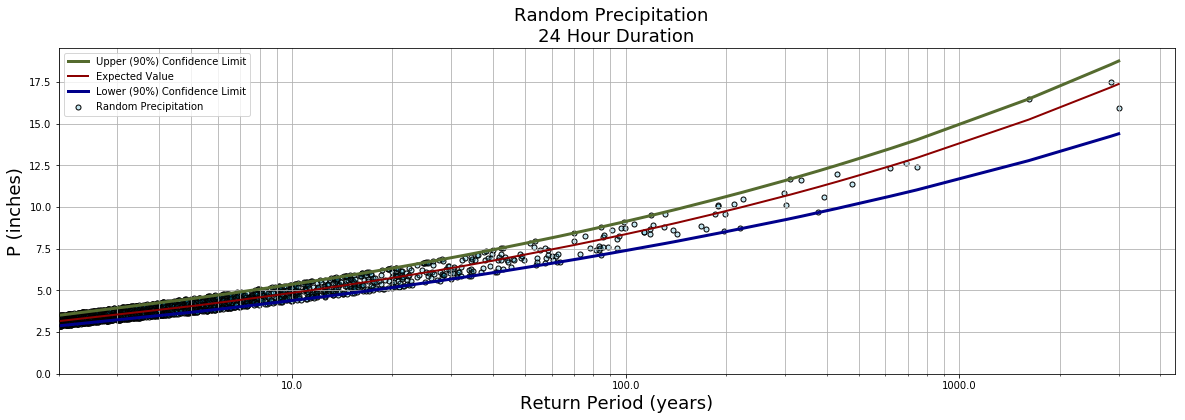

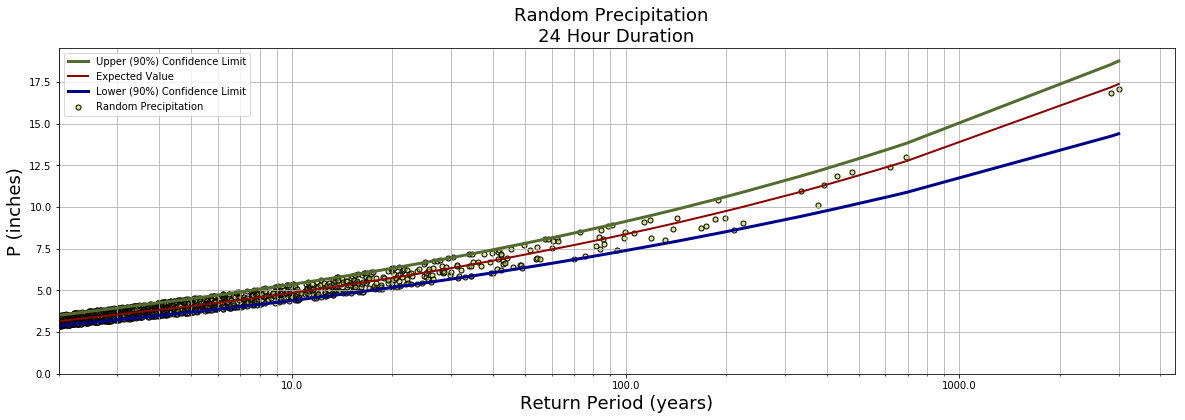

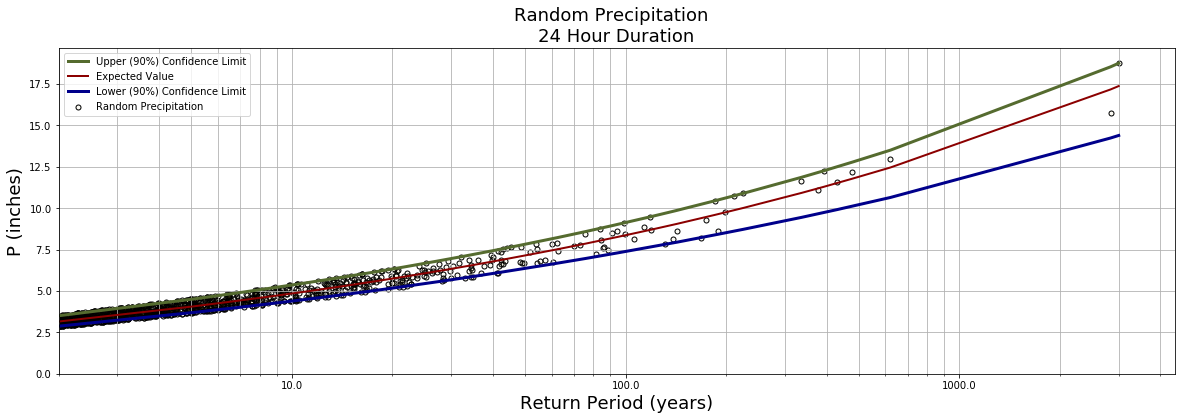

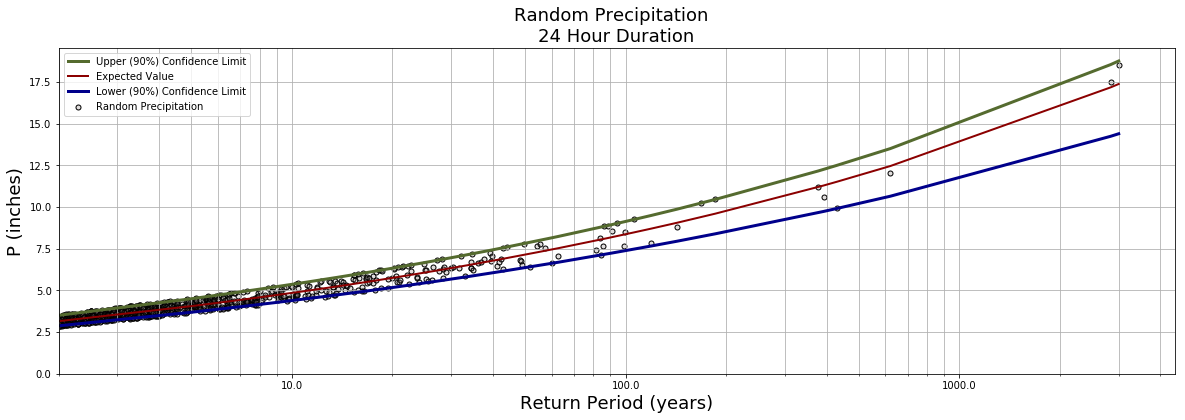

In [12]:
data_tables, random_precip_tables, outfiles = [], [], []

quartiles = range(1, nquartiles+1)  

for i, quartile in enumerate(quartiles):
    start = time.time()
    r_events = generate_random_samples(int(n_events*qrank[i]), seed, display_print = False)
    use_r_events = Truncate_Random_Events(r_events)
    data_table = events_table_random(raw_precip, use_r_events)
    data_table['Quartile'] = quartile
    fitted_precip = find_optimal_curve_std(data_table)
    filename = 'Rand_Precip_Q{0}_{1}_Dur{2}_tempE{3}_convE{4}_volE{5}_Se{6}.csv'.format(quartile, AOI, duration, tempEpsilon, convEpsilon, volEpsilon, seed)
    outfiles.append(filename)
    random_precip_table = RandomizeData(fitted_precip, fitted_precip.shape[0], outputs_dir, filename, duration, seed, plot = display_plots, display_print = False)
    random_precip_table['Quartile'] = quartile
    data_tables.append(data_table)
    random_precip_tables.append(random_precip_table)
    if display_print: print('Data tables for Quartile {} computed in {} Seconds'.format(quartile, str(round((time.time()-start),3))))

### Combine & format:

#### The randomized precipitation data:

In [13]:
random_precip_table = join_rdata_tables(random_precip_tables, 'Precip', display_print)

n_rand_events = random_precip_table.shape[0]

5085 Randomly Selected Events > 2 year RI


,Tr,Random Precipitation,Quartile
1,2.001243,3.300808,1
2,2.004317,3.391597,1


#### The metadata:

In [14]:
data_table = join_rdata_tables(data_tables, 'MetaData', display_print)

,Tr,Ann. Exc. Prob.,ARI,Log10_ARI,Expected Value,Lower (90%),Upper (90%),Quartile
1,2.001243,0.499690,1.443988,0.367409,3.158023,2.877070,3.507821,1
2,2.004317,0.498923,1.447187,0.369622,3.159571,2.878471,3.509533,1


---

## C. Randomly Select Temporal Distributions:

### Reformat and plot the temporal distribution data:

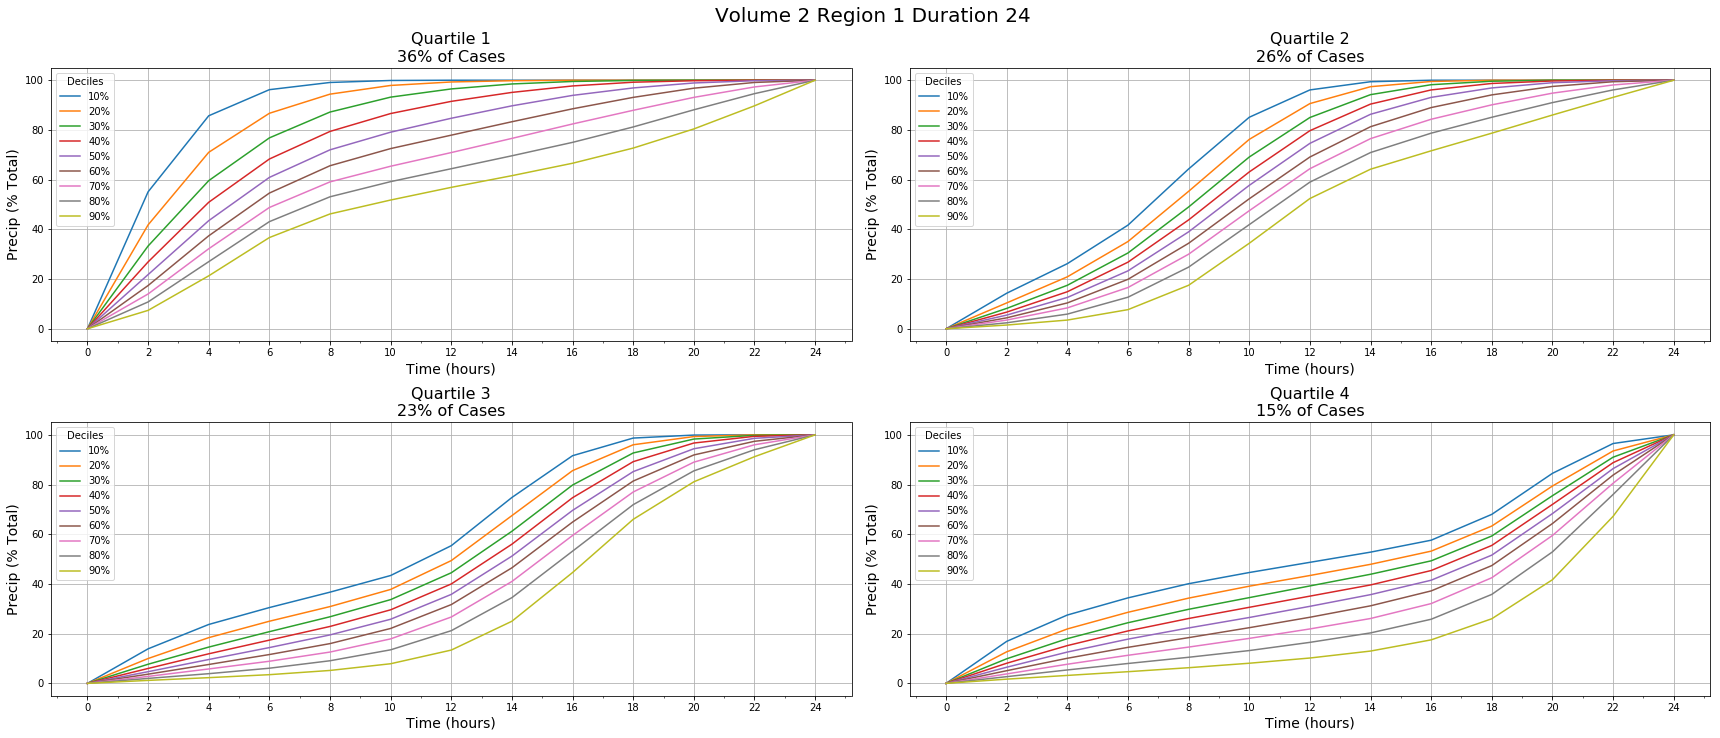

In [15]:
curve_group = get_quartiles(raw_temporals, duration, qrank, qmap, volume, region, plot = display_plots)

### Randomly select the decile and plot:
Note: The decile number is randomly selected for each event, and each event is already associated with a quartile, therefore, given the quartile and the decile, the specific temporal distribution is assigned for each event.

Seed - Deciles: 8947


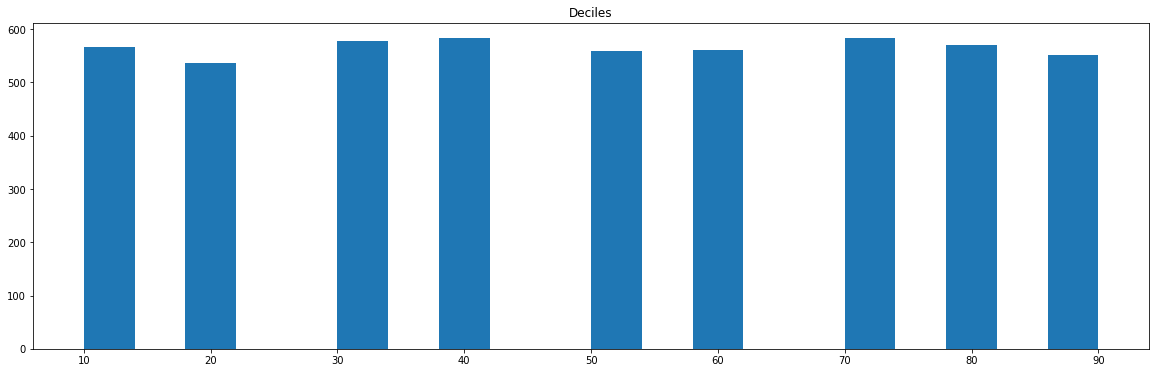

In [16]:
temporals = map_quartiles_deciles(n_rand_events, seed, plot = display_plots, display_print = display_print)

---

## D. Randomly Select Curve Numbers:
- Add the lower and upper values of the specified curve number to a table
- Calculate the standard devation of the log-normal distribution for the curve number using the lower and upper values.
- Randomly select a curve number from the calibrated log-normal distributuion at each recurrance interval

In [17]:
df_CN = prep_cn_table(CN, arc_data)  

fitted_cn = find_optimal_curve_std(df_CN, 'Lower', 'Upper')

filename = "Rand_CN_{0}_{1}_Dur{2}_tempE{3}_convE{4}_volE{5}_Se{6}.csv".format(quartile, AOI, duration, tempEpsilon, convEpsilon, volEpsilon, seed)
outfiles.append(filename)

random_cns = RandomizeData(fitted_cn, n_rand_events, outputs_dir, filename, duration, seed=seed, variable='CN', lower='Lower', upper='Upper', display_print = display_print)

,Random CN
1,90
2,93


None
CN - Seed: 8947


---

## E. Calculate Excess Rainfall:

In [18]:
final_precip, cum_excess, incr_excess, events_metadata =  populate_event_precip_data(random_cns, temporals, random_precip_table, data_table, curve_group, duration, adjust_CN_less24)

### Plot the results

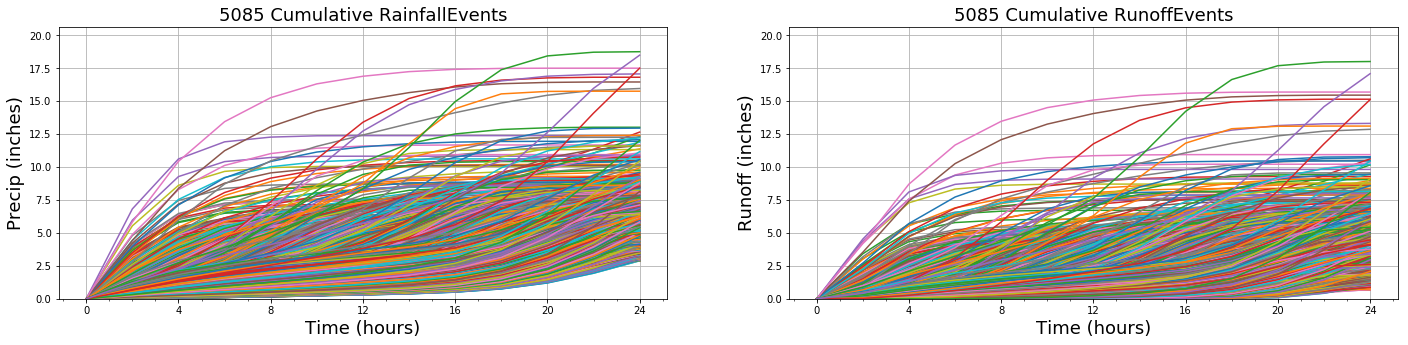

In [19]:
f0 = plot_rainfall_and_excess(final_precip, cum_excess, duration, iplot = papermill)

---

## F. Combine Temporal Curves:

### Perform first convolution:

In [20]:
binData = bin_sorting_dev(incr_excess, nbins, display_print = False)

convolution_dic = hydromet_conv.main(binData, incr_excess, tempEpsilon, convEpsilon, volEpsilon, test_stat_threshold, display_print = False)

#### Extract individual objects from the convolution dictionary:

In [21]:
penult_curves = convolution_dic['penult_curves']

penult_groups = convolution_dic['penult_groups']

penult_tests = convolution_dic['penult_tests']

midbin_curve_df = convolution_dic['midbin_curve_df']

midbin_group = convolution_dic['midbin_group']

midbin_curves = convolution_dic['midbin_curves']

#### Uncomment to plot the middle bin's curve groups:
# y_max = midbin_curve_df.max().max()
# if display_plots: plot_curve_groups(midbin_group, midbin_curves, midbin_curve_df, y_max, False)

#### QC the convolution results:

In [22]:
n_curves_initial = incr_excess.shape[1]
n_curves_penult = len(dic_to_list(penult_groups))
assert(n_curves_initial == n_curves_penult, '# of events not conserved, missing {} events'.format(n_curves_initial-n_curves_penult))

min_test_statistic = min(dic_to_list(penult_tests))
if display_print: print('Minimum Test Statistic:', min_test_statistic)

n_meancurves = penult_curves.shape[1]
penult_reduction = (1-n_meancurves/n_curves_initial)*100.0

if display_print: print("Number of curves reduced by {0}% or {1} curves out of {2} remaining".format(np.round(penult_reduction, 2), n_meancurves, n_curves_initial))

if display_print: print(display(penult_curves.head(2)))

Minimum Test Statistic: 0.000165
Number of curves reduced by 87.45% or 638 curves out of 5085 remaining


,0,1,2,3,4,5,6,7,8,9,...,628,629,630,631,632,633,634,635,636,637
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2.0,0.000509,0.004556,0.05754,0.180244,0.010219,0.028973,0.014526,0.003154,0.002359,0.012965,...,0.125532,0.920456,0.682381,0.094299,3.532696,4.249263,0.295406,0.021157,0.41643,0.887092


None


#### Plot the combined temporal curves:

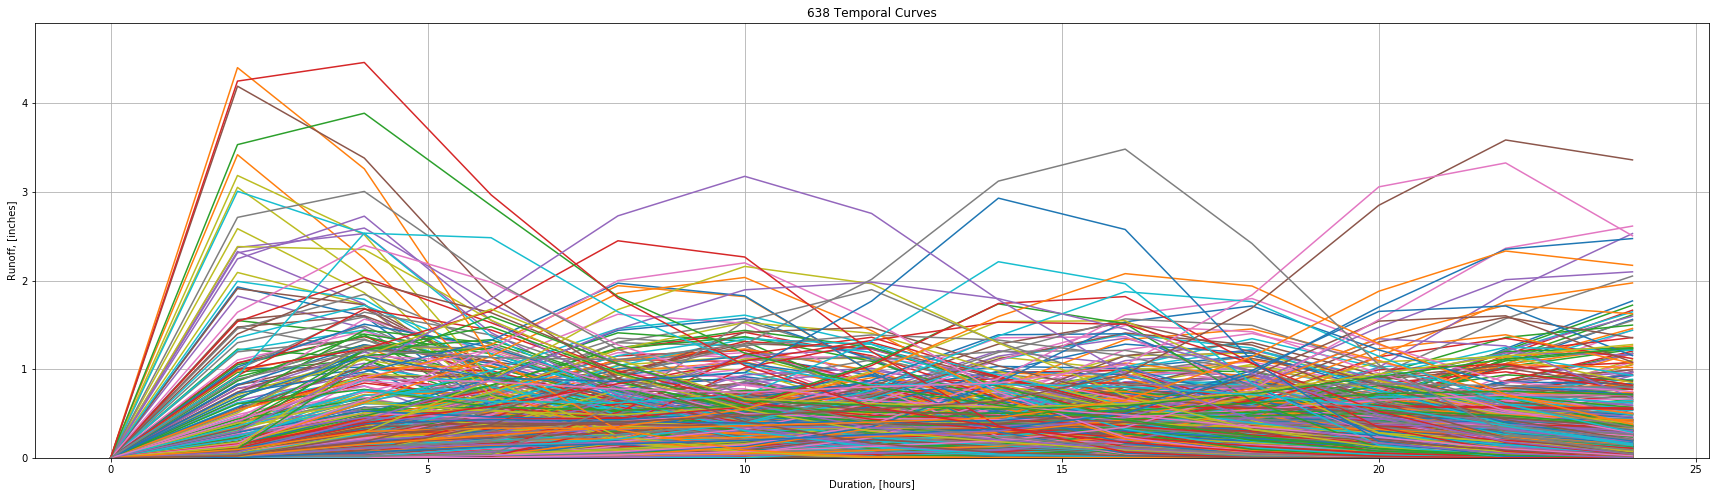

In [23]:
y_max = penult_curves.max().max()

f1 = plot_grouped_curves(penult_curves, y_max, iplot = papermill)

### Perform final convolution:

In [24]:
start = time.time()

adj_tempEpsilon2 = convert_tempEpsilon(tempEpsilon2, incr_excess)

curv_df = prep_data_for_convolution(penult_curves, adj_tempEpsilon2)

test_dic, test_values = conv_ts(curv_df, convEpsilon, volEpsilon)

events = list(curv_df.columns)                                                                         

all_groups = group_curves(test_dic, test_values, events, test_stat_threshold)    

upd_curv = calc_mean_curves(all_groups, curv_df) 

final_curves = calc_mean_curves(all_groups, penult_curves) 

final_groups = map_curve_groups(penult_groups, all_groups, ungroup = True)

final_tests = final_test_stat(final_groups, final_curves, incr_excess, convEpsilon, volEpsilon)

if display_print: print('Processed {0} curves in {1} Minutes'.format(curv_df.shape[1], round(time.time()-start)/60, 3))
    
#### Uncomment to plot the curve groups:
#y_max = incr_excess.max().max()
#if display_plots: plot_curve_groups(final_groups, final_curves, incr_excess, y_max)

Processed 638 curves in 5.316666666666666 Minutes


#### QC the convolution results:

In [25]:
n_curves_final = len(dic_to_list(final_groups))
assert(n_curves_initial == n_curves_final, '# of events not conserved, missing {} events'.format(n_curves_initial-n_curves_final))

min_test_statistic = min(dic_to_list(final_tests))
if display_print: print('Minimum Test Statistic:', min_test_statistic)

n_meancurves = final_curves.shape[1]
final_reduction = (1-n_meancurves/n_curves_initial)*100.0

sb.glue('final_reduction_lst', [final_reduction, n_meancurves, n_curves_initial])

if display_print: print("Number of curves reduced by {0}% or {1} curves out of {2} remaining".format(np.round(final_reduction, 2), n_meancurves, n_curves_initial))

if display_print: print(display(final_curves.head(2)))

Minimum Test Statistic: -1.039019


Number of curves reduced by 92.23% or 395 curves out of 5085 remaining


,0,1,2,3,4,5,6,7,8,9,...,385,386,387,388,389,390,391,392,393,394
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2.0,1.949429,0.960799,1.076307,0.27776,2.208876,0.422056,1.142564,0.112262,0.390019,0.712423,...,0.009121,4.4011,0.013901,0.004616,0.920456,0.682381,3.532696,0.295406,0.41643,0.887092


None


#### Plot the combined temporal curves:

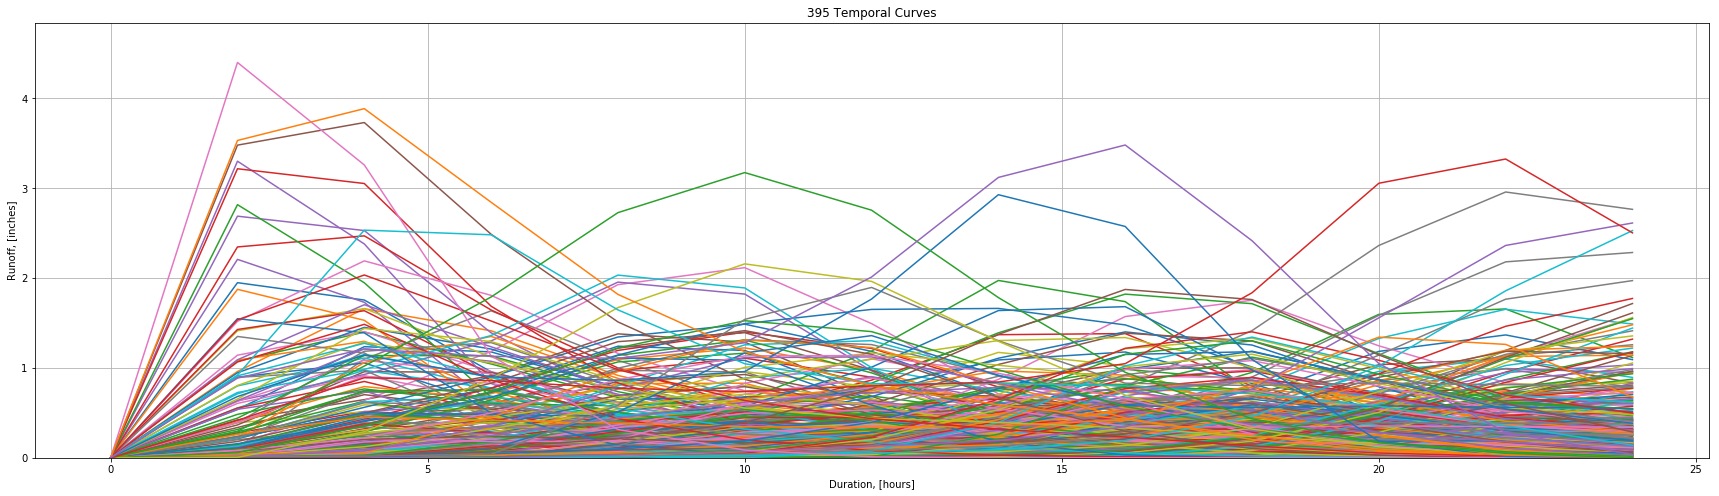

In [26]:
y_max = final_curves.max().max()

f2 = plot_grouped_curves(final_curves, y_max, iplot = papermill)

---

## G. Calculate the Combined Weight and Rename the Groups:

### Adjust duration weight by lower recurrance interval:

In [27]:
adj_dur_weight = adj_duration_weight(dur_weight, lower_limit, display_print)

0.12685961776433383


### Calculate the weight:

In [28]:
curve_weight = Calc_Group_Weight(final_groups, adj_dur_weight, display_print)

Sum of weights: 0.1268596177643341


### Rename the groups according to their weight (largest to smallest):

In [29]:
rename_map = Rename_Final_Groups(curve_weight, duration)

renamed_groups = {}
renamed_tests = {}
renamed_weights = {}

for k, v in rename_map.items():
    renamed_groups[v] = final_groups[k]
    renamed_tests[v] = final_tests[k]
    renamed_weights[v] = curve_weight[k]

renamed_curves = final_curves.rename(index=str, columns=rename_map).copy()
renamed_curves = renamed_curves.reindex(sorted(renamed_curves.columns), axis=1)
renamed_curves.head(2)    

,E2001,E2002,E2003,E2004,E2005,E2006,E2007,E2008,E2009,E2010,...,E2386,E2387,E2388,E2389,E2390,E2391,E2392,E2393,E2394,E2395
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2.0,0.020252,0.071859,0.026548,0.038327,0.006953,0.007657,0.21066,0.008304,0.005042,0.11777,...,0.000849,0.009121,0.013901,0.004616,0.920456,0.682381,3.532696,0.295406,0.41643,0.887092


### Convert the weights dictionary to a dataframe:

In [30]:
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys()))
df_renamed_weights.head(2)

,Weight
E2001,0.003193
E2002,0.002395


---

## H. Save the Results:

### Combined excess rainfall curves:

##### To CSV:

In [31]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_tempE{2}_convE{3}_volE{4}.csv'.format(AOI, duration, tempEpsilon, convEpsilon, volEpsilon))

##### To DSS:

In [32]:
if save_dss:
    AOI = AOI.replace(' ', '_')
    
    scen_name = '{0}_Dur{1}'.format(AOI, duration)
    
    dss_filename = 'Excess_Rainfall_'+scen_name+'_tempE{0}_convE{1}_volE{2}'.format(tempEpsilon, convEpsilon, volEpsilon)
    
    tstep_dic = determine_tstep_units(incr_excess)
    tstep, tstep_units = list(tstep_dic.keys())[0], list(tstep_dic.values())[0]

    dss_map(outputs_dir, variable, tstep, tstep_units, units, data_type)
    
    excess_df_to_input(outputs_dir, renamed_curves, tstep, tstep_units, scen_name)
    
    make_dss_file(outputs_dir, bin_dir, dssutil, dss_filename, remove_temp_files = True, display_print = display_print)  

Dss File written to C:\Users\sputnam\Documents\GitHub\pfra-hydromet\Outputs\Excess_Rainfall_DC_Dur24_tempE4_convE100_volE67.dss


### Event weights:

In [33]:
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_tempE{2}_convE{3}_volE{4}.csv'.format(AOI, duration, tempEpsilon, convEpsilon, volEpsilon))

### All metadata:

In [34]:
metadata = {}

metadata['groups'] = dic_key_to_str(renamed_groups)
metadata['test_stat'] = dic_key_to_str(renamed_tests)
metadata['precip'] = final_precip.to_dict()
metadata['cum_excess'] = cum_excess.to_dict()
metadata['incr_excess'] = incr_excess.to_dict()
metadata['events_metadata'] = extract_event_metadata(outfiles, events_metadata,  outputs_dir, remove_intermediates)

with open(os.path.join(str(outputs_dir.resolve()),'Metadata_{0}_Dur{1}_tempE{2}_convE{3}_volE{4}.json'.format(AOI, duration, tempEpsilon, convEpsilon, volEpsilon)), 'w') as f:
    json.dump(metadata, f)
    
if display_print: print('Runtime: {} Minutes'.format(round(time.time()-start_time)/60, 3))  

Runtime: 56.13333333333333 Minutes


---

## END